<a href="https://colab.research.google.com/github/TaylorShiehUSI/Github-Colab-test/blob/main/20220814_2230.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [27]:
# 下載資料套件
import requests as r

# 資料處理套件
from lxml import etree
import json
from datetime import datetime, date
import pandas as pd

# 財經套件
# import yfinance as yf

# 畫圖套件
import plotly.graph_objects as go

In [28]:
## down load stock data
def get_tw_stock_data(start_year, start_month, end_year, end_month, stock_code):
    start_date = str(date(start_year, start_month, 1))
    end_date = str(date(end_year, end_month, 1))
    month_list = pd.date_range(start_date, end_date, freq='MS').strftime("%Y%m%d").tolist()
    
    df = pd.DataFrame()
    for month in month_list:
        url = "https://www.twse.com.tw/exchangeReport/STOCK_DAY?response=json&date="+ month + "&stockNo=" + str(stock_code)
        res = r.get(url)
        stock_json = res.json()
        stock_df = pd.DataFrame.from_dict(stock_json['data'])
        df = df.append(stock_df, ignore_index = True)
        
    # 資料轉型
    for col in [0, 1, 2, 3, 4, 5, 6, 8]:
        for row in range(df.shape[0]):
            # 把"日期"從字串(string)換成時間(datetime)，並將民國年換成西元年
            if col == 0:
                day = df.iloc[row,0].split('/')
                df.iloc[row, 0] = datetime(int(day[0]) + 1911, int(day[1]), int(day[2]))  
            # 把"開盤價", "最高價", "最低價", "收盤價"帶有逗號的字串(string)換成浮點數(float) 
            elif col != 0:
                df.iloc[row, col] = float(df.iloc[row,col].replace(',', ''))
    
    df.columns = ['日期', '成交股數', '成交金額', '開盤價', '最高價', '最低價', '收盤價', '漲跌價差', '成交筆數']
    return df

In [29]:
##  input Start - End , and stock index
stock_df = get_tw_stock_data(start_year = 2022, 
                start_month = 1, 
                end_year = 2022, 
                end_month = 8, 
                stock_code = 2330)
stock_df

ConnectionError: ignored

In [15]:
stock_df.to_csv('2230.csv',encoding='utf-8_sig')

NameError: ignored

In [ ]:
## Data Processing // Add is_up
import numpy as np

stock_df['is_up'] = (stock_df['開盤價'].shift(-1) - stock_df['收盤價'] >0).astype('int')
stock_df['高低差'] = (stock_df['最高價'] - stock_df['最低價']).astype('int')
stock_df['漲跌價差'] = (stock_df['收盤價'] - stock_df['開盤價']).astype('int')
stock_df['單筆股數'] = (stock_df['成交股數']/stock_df['成交筆數']).astype('int')

def one_hot(targets, nb_classes):
    return np.eye(nb_classes)[np.array(targets).reshape(-1)]
y_data = one_hot(stock_df['is_up'], 2)
stock_df.head()

,日期,成交股數,成交金額,開盤價,最高價,最低價,收盤價,漲跌價差,成交筆數,is_up,高低差,單筆股數
0,2021-01-04 00:00:00,39489959.0,21127581248.0,530.0,540.0,528.0,536.0,6,33316.0,0,12,1185
1,2021-01-05 00:00:00,34839391.0,18761831567.0,536.0,542.0,535.0,542.0,6,28512.0,1,7,1221
2,2021-01-06 00:00:00,55614434.0,30572783229.0,555.0,555.0,541.0,549.0,-6,55462.0,1,14,1002
3,2021-01-07 00:00:00,53392763.0,30018630685.0,554.0,570.0,553.0,565.0,11,47905.0,1,17,1114
4,2021-01-08 00:00:00,62957148.0,36339702855.0,580.0,580.0,571.0,580.0,0,56426.0,0,9,1115


In [ ]:
## group = data.groupby("company")
## list(group)
## data.groupby("company").agg('mean')
## data.groupby('company').agg({'salary':'median','age':'mean'})
## avg_salary_dict = data.groupby('company')['salary'].mean().to_dict()
​## data['avg_salary'] = data['company'].map(avg_salary_dict)

## Prepare Feature Data
X_data = stock_df.drop(['日期','成交股數','開盤價','最高價','最低價','收盤價','is_up','單筆股數'], axis=1)
X_data.head()
#X_data.columns

,成交金額,漲跌價差,成交筆數,高低差
0,21127581248.0,6,33316.0,12
1,18761831567.0,6,28512.0,7
2,30572783229.0,-6,55462.0,14
3,30018630685.0,11,47905.0,17
4,36339702855.0,0,56426.0,9


In [ ]:
## Normalized
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_data)
scaled = scaler.fit_transform(X_data)
X_data = pd.DataFrame(scaled, columns=X_data.columns)
#print(X_data)
X_data.head()

,成交金額,漲跌價差,成交筆數,高低差
0,-0.075211,1.013110,-0.380796,0.616428
1,-0.251156,1.013110,-0.489071,-0.385522
2,0.627244,-0.902884,0.118342,1.017207
3,0.586031,1.811441,-0.051981,1.618377
4,1.056139,0.055113,0.140070,0.015258


In [ ]:
## train the model, with preparing the data
from sklearn.model_selection import train_test_split
from keras import backend as K

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

# keep one hot Encoding in y for Cross Table
y_test_cross = y_test
y_test_cross = np.argmax(y_test_cross,axis=1)
print(y_test_cross)
# print(y_test_cross)

X_train = K.cast_to_floatx(X_train)
y_train = K.cast_to_floatx(y_train)
X_test = K.cast_to_floatx(X_test)
y_test = K.cast_to_floatx(y_test)

[0 1 1 0 1 1 1 0 0 1 1 1 1 0 1 0 1 1 0 1 0 0 0 0 1 0 1 0 1 0 0 1 1 1 1 0 1
 1 1 1 1 0 1 0 1 0 0 0 0 0 1 0 1 1 0 0 1 1 0 1 0 0 0 0 1 1 0 1 1 0 1 0 0 1
 1 0 1 1 1]


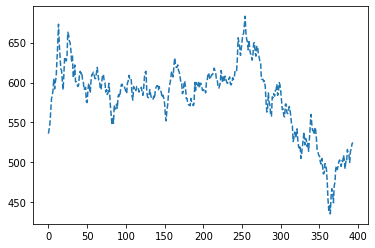

In [ ]:
from matplotlib import pyplot as plt
plt.plot( stock_df['收盤價'], '--')
plt.show()


In [ ]:
import tensorflow as tf
from tensorflow import keras 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten


In [ ]:
## set up model, and print the model summary
model = Sequential()
model.add(Dense(units = 64,
                input_shape=X_train.shape[1:],
                kernel_initializer = 'normal',
                activation='relu'))
#model.add(Dropout(0.25))
model.add(Dense(units = 16,
                kernel_initializer = 'normal',
                activation='relu'))
model.add(Dense(units = 16,
                kernel_initializer = 'normal',
                activation='relu'))
model.add(Dense(units = 8,
                kernel_initializer = 'normal',
                activation='relu'))
model.add(Dense(units = 2,
                kernel_initializer = 'normal',
                activation='softmax'))
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 64)                320       
                                                                 
 dense_21 (Dense)            (None, 16)                1040      
                                                                 
 dense_22 (Dense)            (None, 16)                272       
                                                                 
 dense_23 (Dense)            (None, 8)                 136       
                                                                 
 dense_24 (Dense)            (None, 2)                 18        
                                                                 
Total params: 1,786
Trainable params: 1,786
Non-trainable params: 0
_________________________________________________________________


In [ ]:
## train the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 
model.fit(x = X_train,
          y = y_train,
          validation_split = 0.2,
          batch_size=64,
          epochs=800,
          verbose = 2) 

Epoch 1/800
4/4 - 1s - loss: 0.3411 - accuracy: 0.8730 - val_loss: 3.0650 - val_accuracy: 0.5397 - 727ms/epoch - 182ms/step
Epoch 2/800
4/4 - 0s - loss: 0.4257 - accuracy: 0.8492 - val_loss: 2.5749 - val_accuracy: 0.5079 - 44ms/epoch - 11ms/step
Epoch 3/800
4/4 - 0s - loss: 0.3625 - accuracy: 0.8690 - val_loss: 3.5357 - val_accuracy: 0.4286 - 36ms/epoch - 9ms/step
Epoch 4/800
4/4 - 0s - loss: 0.2242 - accuracy: 0.9087 - val_loss: 2.9151 - val_accuracy: 0.4921 - 37ms/epoch - 9ms/step
Epoch 5/800
4/4 - 0s - loss: 0.2156 - accuracy: 0.9087 - val_loss: 2.6151 - val_accuracy: 0.5079 - 34ms/epoch - 9ms/step
Epoch 6/800
4/4 - 0s - loss: 0.2200 - accuracy: 0.9127 - val_loss: 2.9756 - val_accuracy: 0.5079 - 53ms/epoch - 13ms/step
Epoch 7/800
4/4 - 0s - loss: 0.1949 - accuracy: 0.9246 - val_loss: 3.2169 - val_accuracy: 0.4921 - 46ms/epoch - 12ms/step
Epoch 8/800
4/4 - 0s - loss: 0.1787 - accuracy: 0.9405 - val_loss: 2.8877 - val_accuracy: 0.4127 - 38ms/epoch - 9ms/step
Epoch 9/800
4/4 - 0s - los

In [ ]:
## Evalaute evaluate Accury, and print out
score = model.evaluate(X_test, y_test, verbose=1)
print()  
print("\t[Info] Accuracy of testing data = {:2.1f}%".format(score[1]*100.0)) 
#print('score', score)

3/3 [==============================] - 0s 4ms/step - loss: 3.7733 - accuracy: 0.5316

	[Info] Accuracy of testing data = 53.2%


In [ ]:

# 預測(prediction)
# X = X_test[0:20,:]
# #predictions = model.predict_classes(X)
# mypredictions = model.predict(X).astype('int64')
# classes_x = np.argmax(mypredictions, axis = 1)
# classes_x

#myPredict = model.predict_classes( X_test).astype('int64')
myPredict=model.predict(X_test).astype('int64') 
classes_x=np.argmax(myPredict,axis=1)
#print(classes_x)
#classes_x

In [ ]:
#y_test
#混淆矩陣 (confusion matrix)  -> cross table
print(y_test_cross)
print(classes_x)
pd.crosstab(y_test_cross,classes_x)


[1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 0 1 1 0 0 0 0 0 1 1 0 1 1 0 0 0 1 0 1 0 0 1
 0 1 1 0 0 0 0 0 0 0 1 1 0 1 1 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 1 1
 0 1 0 0 1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0]


col_0,0
row_0,
0,47
1,32
